In [144]:
!pip install transformers datasets torch scikit-learn matplotlib

In [145]:
# ===========================
# ALL IMPORTS
# ===========================

# Data handling
import pandas as pd
import numpy as np

# Machine Learning & metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# PyTorch
import torch

# Hugging Face Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

# Hugging Face Datasets
from datasets import Dataset

# Plotting
import matplotlib.pyplot as plt


**Step 1: Load dataset**

In [146]:
df = pd.read_csv("/content/Prepared_EmotionDataset.csv")
df.head()

,cleaned_text,emotion
0,اعتذر ان بدالك شي غير اني احبك,love
1,من بين مجاميع زفه عفش العروسه اللي راحوا يمثلو...,joy
2,الدموع ليست هي الحزن هو ان تستطيع ان تمنع نفسك...,sad
3,ارسمك في عيني علي حزه اشوق ويا زين حالي يوم اش...,love
4,فلسطين يوم ما دخلوا اليهود ارضك زعلوا العرب خا...,sad


**Step 2: Optional simple augmentation for “love” class**

In [147]:
# Simple augmentation: duplicate "love" samples with minor text changes
love_samples = df[df['emotion'] == 'love'].copy()

# Example: add a space or punctuation (very basic augmentation)
augmented_texts = love_samples['cleaned_text'].apply(lambda x: x + " .").tolist()
augmented_df = pd.DataFrame({'cleaned_text': augmented_texts, 'emotion': 'love'})

# Combine with original dataset
df_aug = pd.concat([df, augmented_df], ignore_index=True)
df_aug = df_aug.sample(frac=1, random_state=42)  # Shuffle


**Step 3: Encode labels**

In [148]:
le = LabelEncoder()
df_aug['label'] = le.fit_transform(df_aug['emotion'])
num_labels = len(le.classes_)
df_aug.head()




,cleaned_text,emotion,label
918,الحب رحله الروح من الالم الي الالم بحثا عن الا...,love,1
525,من سحر الحب ان تري وجه من تحب هو الوجه الذي تض...,love,1
567,مش عارف الم المنهج,sad,2
656,لا تكن بلا حب كي لا تشعر بانك ميت مت في الحب و...,love,1
915,ربي جابك لي هديه من السماء ياسمين الشوق الاحسا...,love,1


**Step 4: Load tokenizer and model**

In [149]:
model_name = "aubmindlab/bert-base-arabertv02"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Step 5: Tokenize the dataset**

In [150]:
dataset = Dataset.from_pandas(df_aug)

def tokenize(batch):
    return tokenizer(batch['cleaned_text'], padding=True, truncation=True)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])




Map:   0%|          | 0/993 [00:00<?, ? examples/s]

**Step 6: Split dataset**

In [151]:
train_testvalid = dataset.train_test_split(test_size=0.3, seed=42)
valid_test = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)

train_dataset = train_testvalid['train']
valid_dataset = valid_test['train']
test_dataset = valid_test['test']

print(f"Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Test: {len(test_dataset)}")


Train: 695, Valid: 149, Test: 149


**Step 7: Define training arguments**

In [152]:
training_args = TrainingArguments(
    output_dir="./arabert-emotion",
    learning_rate=1e-5,               # small LR for stability
    per_device_train_batch_size=8,    # small batch
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to=["tensorboard"]
)



**Step 9: Define metrics**

In [153]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1}


**Step 10: Create Trainer with Early Stopping**

In [154]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)]
)


/tmp/ipython-input-1909226421.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step 11: Train the model

In [155]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.858300,0.623880,0.704698,0.656756
2,0.567300,0.501995,0.785235,0.781765
3,0.374100,0.495547,0.805369,0.798586
4,0.249800,0.460232,0.818792,0.815151
5,0.168200,0.465708,0.812081,0.814291
6,0.105500,0.508421,0.832215,0.828221
7,0.081100,0.531177,0.838926,0.835894
8,0.056600,0.627993,0.818792,0.813449


TrainOutput(global_step=696, training_loss=0.3076139085594265, metrics={'train_runtime': 242.7874, 'train_samples_per_second': 28.626, 'train_steps_per_second': 3.583, 'total_flos': 191435567132880.0, 'train_loss': 0.3076139085594265, 'epoch': 8.0})

**Step 12: Evaluate on test set**

In [167]:
from sklearn.metrics import accuracy_score, classification_report

# Run evaluation
eval_results = trainer.evaluate()

print("\n📌 Overall Evaluation Results:")
print(eval_results)

# Predict on test set
preds_output = trainer.predict(test_dataset)
preds = preds_output.predictions.argmax(axis=1)
true_labels = preds_output.label_ids

# Per-class report
print("\n📌 Classification Report (per class F1 score):")
print(classification_report(true_labels, preds, target_names=class_labels))




📌 Overall Evaluation Results:
{'eval_loss': 0.5311769843101501, 'eval_accuracy': 0.8389261744966443, 'eval_f1': 0.835894133234045, 'eval_runtime': 0.6905, 'eval_samples_per_second': 215.792, 'eval_steps_per_second': 14.483, 'epoch': 8.0}

📌 Classification Report (per class F1 score):
              precision    recall  f1-score   support

         joy       0.64      0.72      0.68        32
        love       0.93      0.86      0.89        76
         sad       0.81      0.85      0.83        41

    accuracy                           0.83       149
   macro avg       0.79      0.81      0.80       149
weighted avg       0.83      0.83      0.83       149



In [168]:
final_accuracy = accuracy_score(true_labels, preds)
print(f"🔍 Final Test Accuracy: {final_accuracy:.4f}")

🔍 Final Test Accuracy: 0.8255


**Step 11: Plot training & validation performance**

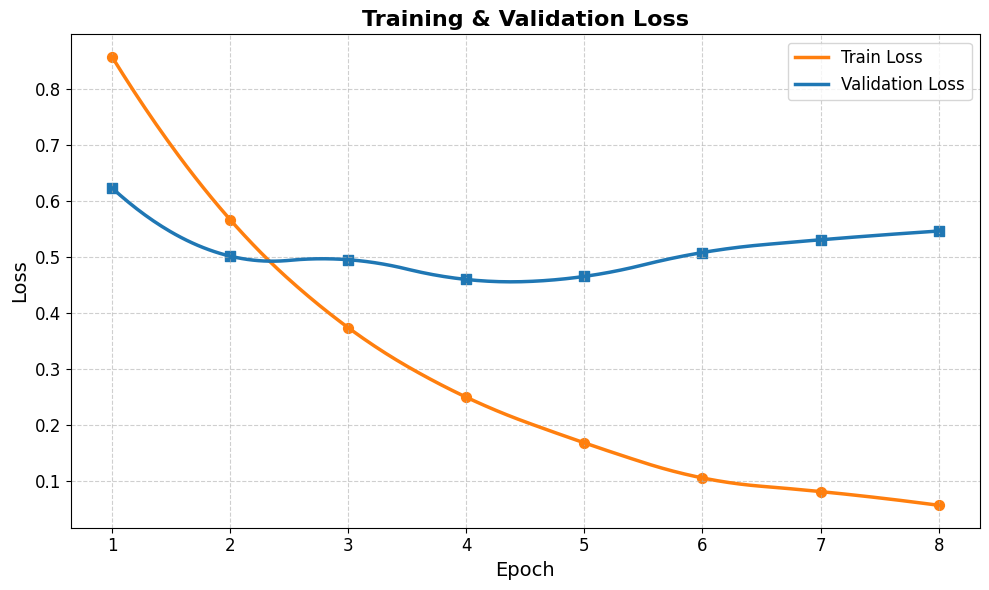

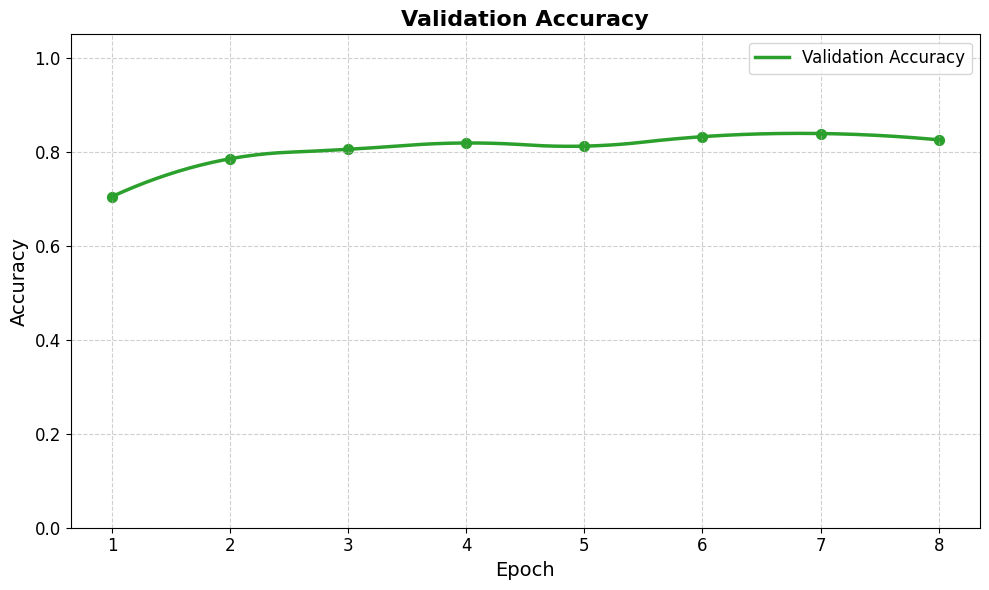

In [157]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import make_interp_spline
import numpy as np

# Extract epochs and metrics
logs = trainer.state.log_history

# Filter for training loss logs
train_loss_logs = [log for log in logs if 'loss' in log and 'epoch' in log and 'eval_loss' not in log]
train_epochs = np.array([log['epoch'] for log in train_loss_logs])
train_loss = np.array([log['loss'] for log in train_loss_logs])

# Filter for evaluation logs, keeping only the last entry for each unique epoch
eval_data_per_epoch = {}
for log in logs:
    if 'eval_loss' in log and 'eval_accuracy' in log and 'epoch' in log:
        epoch = log['epoch']
        eval_data_per_epoch[epoch] = {
            'eval_loss': log['eval_loss'],
            'eval_accuracy': log['eval_accuracy']
        }

sorted_eval_epochs_keys = sorted(eval_data_per_epoch.keys())
eval_epochs = np.array(sorted_eval_epochs_keys)
eval_loss = np.array([eval_data_per_epoch[e]['eval_loss'] for e in sorted_eval_epochs_keys])
eval_acc = np.array([eval_data_per_epoch[e]['eval_accuracy'] for e in sorted_eval_epochs_keys])

# Determine the range for smoothing
min_epoch = min(train_epochs.min(), eval_epochs.min()) if train_epochs.size > 0 and eval_epochs.size > 0 else 0
max_epoch = max(train_epochs.max(), eval_epochs.max()) if train_epochs.size > 0 and eval_epochs.size > 0 else 5
epochs_smooth = np.linspace(min_epoch, max_epoch, 300)

# Smooth the curves, using k=2 (quadratic) for a small number of points
train_loss_smooth = make_interp_spline(train_epochs, train_loss, k=2)(epochs_smooth)
eval_loss_smooth = make_interp_spline(eval_epochs, eval_loss, k=2)(epochs_smooth)
eval_acc_smooth = make_interp_spline(eval_epochs, eval_acc, k=2)(epochs_smooth)

# --- Loss Plot ---
plt.figure(figsize=(10,6))
plt.plot(epochs_smooth, train_loss_smooth, label='Train Loss', color='#FF7F0E', linewidth=2.5)
plt.plot(epochs_smooth, eval_loss_smooth, label='Validation Loss', color='#1F77B4', linewidth=2.5)
plt.scatter(train_epochs, train_loss, color='#FF7F0E', s=50, marker='o')  # actual points
plt.scatter(eval_epochs, eval_loss, color='#1F77B4', s=50, marker='s')    # actual points
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Training & Validation Loss", fontsize=16, fontweight='bold')
plt.xticks(eval_epochs, fontsize=12)
plt.yticks(fontsize=12)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# --- Accuracy Plot ---
plt.figure(figsize=(10,6))
plt.plot(epochs_smooth, eval_acc_smooth, label='Validation Accuracy', color='#2CA02C', linewidth=2.5)
plt.scatter(eval_epochs, eval_acc, color='#2CA02C', s=50, marker='o')  # actual points
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Validation Accuracy", fontsize=16, fontweight='bold')
plt.xticks(eval_epochs, fontsize=12)
plt.yticks(fontsize=12)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

**Step 12: Plot confusion matrix**

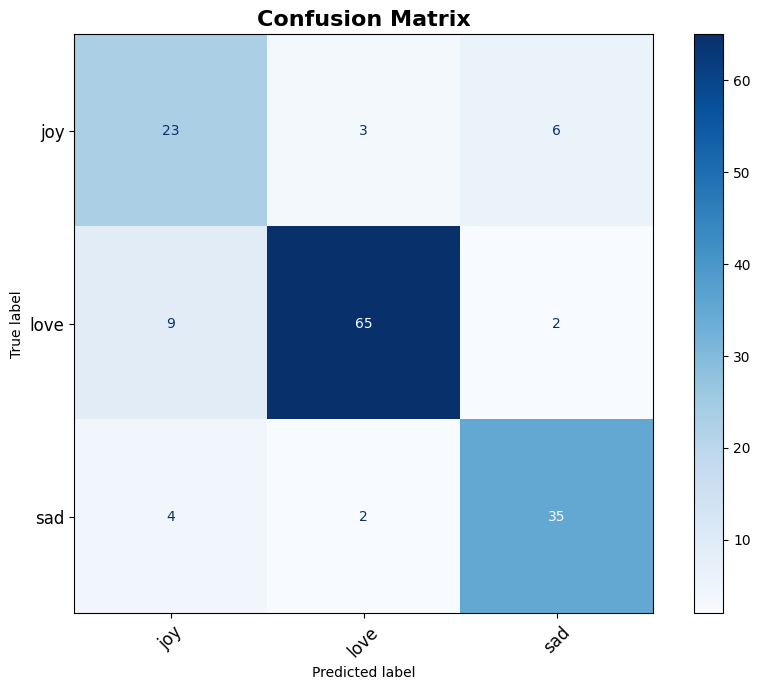

In [158]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
preds_output = trainer.predict(test_dataset)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(9,7))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True, xticks_rotation=45)
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


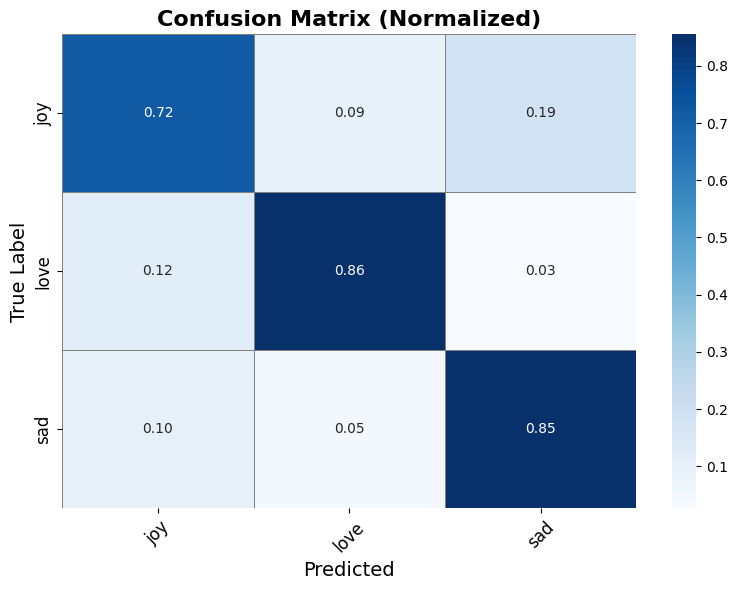

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)
cm_norm = cm / cm.sum(axis=1, keepdims=True)  # normalize rows

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels,
            linewidths=0.5, linecolor="gray")

plt.title("Confusion Matrix (Normalized)", fontsize=16, fontweight="bold")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


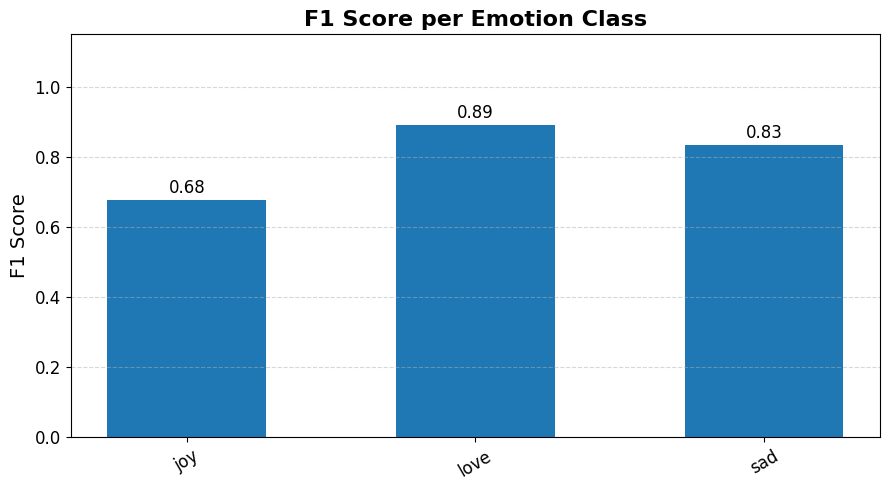

In [172]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get classification report as a dict
report = classification_report(true_labels, preds, target_names=class_labels, output_dict=True)

# Create dataframe
df_report = pd.DataFrame(report).transpose()
f1_scores = df_report.iloc[:-3]["f1-score"]  # remove accuracy, macro avg, weighted avg

# Bar plot
plt.figure(figsize=(9,5))
bars = plt.bar(class_labels, f1_scores, width=0.55)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}",
             ha='center', fontsize=12)

plt.title("F1 Score per Emotion Class", fontsize=16, fontweight="bold")
plt.ylabel("F1 Score", fontsize=14)
plt.ylim(0, 1.15)
plt.xticks(fontsize=12, rotation=30)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [173]:
save_path = "/content/AraBERT_emotion_model"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("Model saved at:", save_path)


Model saved at: /content/AraBERT_emotion_model


In [174]:
from google.colab import files
import shutil

# Compress folder
zip_path = save_path + ".zip"
shutil.make_archive(save_path, 'zip', save_path)

# Download
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [160]:
trainer.save_model("./arabert-emotion-final")
tokenizer.save_pretrained("./arabert-emotion-final")


('./arabert-emotion-final/tokenizer_config.json',
 './arabert-emotion-final/special_tokens_map.json',
 './arabert-emotion-final/vocab.txt',
 './arabert-emotion-final/added_tokens.json',
 './arabert-emotion-final/tokenizer.json')

In [162]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import pandas as pd

# Load tokenizer & model
model_path = "/content/arabert-emotion-final"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Get class labels
class_labels = ['joy','love','sad']  # replace with your actual labels order


In [163]:
def predict_emotion(text):
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

    # Get model outputs
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Apply softmax to get probabilities
    probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    # Get predicted emotion
    pred_index = probs.argmax()
    pred_emotion = class_labels[pred_index]
    pred_confidence = probs[pred_index]

    # Build a DataFrame to show all probabilities
    prob_df = pd.DataFrame({
        "Emotion": class_labels,
        "Probability": probs
    }).sort_values(by="Probability", ascending=False)

    return pred_emotion, pred_confidence, prob_df


In [164]:
text = "أنا سعيد جدًا اليوم"  # Example text
emotion, confidence, prob_df = predict_emotion(text)

print(f"Predicted Emotion: {emotion} ({confidence*100:.2f}%)\n")
print("Probabilities for all emotions:")
print(prob_df)


Predicted Emotion: joy (98.01%)

Probabilities for all emotions:
  Emotion  Probability
0     joy     0.980129
1    love     0.011021
2     sad     0.008850


In [165]:
text = "أنا حزينه "  # Example text
emotion, confidence, prob_df = predict_emotion(text)

print(f"Predicted Emotion: {emotion} ({confidence*100:.2f}%)\n")
print("Probabilities for all emotions:")
print(prob_df)

Predicted Emotion: sad (96.41%)

Probabilities for all emotions:
  Emotion  Probability
2     sad     0.964095
0     joy     0.028378
1    love     0.007527


In [166]:
text = "احب"  # Example text
emotion, confidence, prob_df = predict_emotion(text)

print(f"Predicted Emotion: {emotion} ({confidence*100:.2f}%)\n")
print("Probabilities for all emotions:")
print(prob_df)

Predicted Emotion: love (93.67%)

Probabilities for all emotions:
  Emotion  Probability
1    love     0.936747
0     joy     0.054446
2     sad     0.008807
